In [13]:
# Uncomment below if you want to run this file only
%run main.ipynb
#%run data_cleaning.ipynb
#%run data_visualization.ipynb
#%run feature_engineering.ipynb

In [14]:
# Read the CSV From FEATURE ENGINEERING data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_feature_engineering):
    dataset = s3_utils.read_csv_from_s3(output_file_key_data_feature_engineering)

In [15]:
X = dataset.drop(columns=['target'])
y = dataset['target']

In [16]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)

X_imputed = imputer.transform(X)

# Convert the imputed data back to a DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [18]:
X_resampled.shape, y_resampled.shape

((652530, 21), (652530,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for the random search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   scoring='roc_auc',
                                   cv=5,
                                   random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [21]:
best_params = {'n_estimators': 200, 'min_samples_split': 2, 
               'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
rf_classifier = RandomForestClassifier(**best_params,random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [22]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Precision: 1.0
Recall: 0.0006919617114519663
F1 Score: 0.0013829664630632707
ROC AUC: 0.500345980855726


In [23]:
#With SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

After performing randomsearchCV in sagemaker, we got these parameters:

In [24]:
best_params = {'n_estimators': 200, 'min_samples_split': 5,
               'min_samples_leaf': 2, 'max_depth': None,
               'bootstrap': False}
rf_classifier = RandomForestClassifier(**best_params,random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

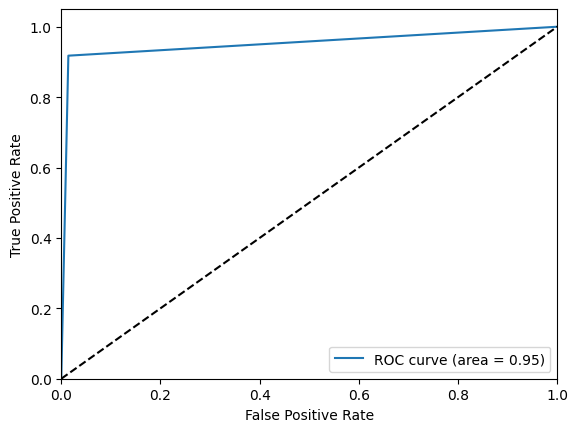

In [25]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [26]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Precision: 0.9847461892829396
Recall: 0.9177527585714577
F1 Score: 0.9500699411438676
ROC AUC: 0.9517423683748888


In [ ]:
import joblib

joblib.dump(rf_classifier, 'random_forest.pkl')


['random_forest.pkl']

In [ ]:
import tarfile
with tarfile.open('model_artifacts.tar.gz', 'w:gz') as tar:
    tar.add('random_forest.pkl')